# Чтение данных

In [1]:
ROOT_DIR = '3-Full-Cycles 275-295 gallons'

### Вспомогательные методы для чтения и разбора данных

In [4]:
import os
import itertools
import pandas as pd
import numpy as np
import datetime
import re


def parse_datetime(line):
    return datetime.datetime.strptime(line[5:], '%Y-%m-%d %H:%M:%S.%f')


def parse_temperature(line):
    return float(line[14:-3])


def parse_pressure(line):
    return float(line[22:-5])


def parse_battery_voltage(line):
    return float(line[24:-6])


def parse_pot_setting(line):
    values = re.sub(r'[A-z;=>:]', ' ', line.replace('POT1', '').replace('POT2', '')).split()
    return map(float, values)

def parse_gallons(gal_dir_name):
    return float(re.sub(r'[^\d]', '', gal_dir_name))


def yield_gallon_dir(sample_dir):
    gallons = parse_gallons(sample_dir)
    sample_files = os.listdir(os.path.join(ROOT_DIR, sample_dir))
    for sample_file in sample_files:
        with open(os.path.join(ROOT_DIR, sample_dir, sample_file)) as f:
            lines = map(lambda l: l[:-1], f)
            yield {
                'gallons': gallons,
                'datetime': parse_datetime(lines[0]),
                'temperature': parse_temperature(lines[1]),
                'pressure': parse_pressure(lines[2]),
                'battery_voltage': parse_battery_voltage(lines[3]),
                'pot_setting': parse_pot_setting(lines[4]),
                'sample': np.array(map(int, lines[5:]))
            } 

### Непосредственно чтение данных

In [6]:
samples_dirs = filter(lambda d: d.endswith('gal'), os.listdir(ROOT_DIR))


samples_df = pd.DataFrame(list(
    itertools.chain.from_iterable((yield_gallon_dir(d) for d in samples_dirs))
))

print samples_df.shape
samples_df.sample(10)

,battery_voltage,datetime,gallons,pot_setting,pressure,sample,temperature
214,6.06,2016-01-15 19:33:41.374351,283,"[192.0, 127.0, 12.5]",28.35,"[1787, 2332, 2418, 4095, 66, 4095, 789, 3258, ...",16.2
942,6.06,2016-01-15 19:17:23.103488,282,"[192.0, 127.0, 12.5]",28.35,"[4095, 67, 996, 555, 2503, 2250, 1677, 2165, 1...",16.6
421,6.00,2016-01-14 20:48:41.802099,285,"[192.0, 127.0, 12.5]",28.65,"[1834, 68, 1546, 4095, 1305, 1289, 4095, 448, ...",13.0
1050,6.06,2016-01-14 19:43:22.016532,284,"[192.0, 127.0, 12.5]",28.65,"[3891, 2040, 71, 4079, 1575, 67, 1930, 1368, 4...",12.9
1223,6.17,2016-01-14 16:47:48.956426,276,"[192.0, 127.0, 12.5]",28.71,"[679, 116, 2899, 2413, 1303, 2743, 1612, 4095,...",11.6
833,5.99,2016-01-12 20:10:13.158176,279,"[192.0, 127.0, 12.5]",28.64,"[559, 3055, 1614, 76, 2087, 516, 4095, 1557, 3...",8.6
690,6.03,2016-01-12 19:38:27.474759,277,"[192.0, 127.0, 12.5]",28.61,"[3619, 1568, 3132, 1228, 81, 2779, 4053, 1771,...",9.9
133,6.17,2016-01-14 17:16:29.251541,278,"[192.0, 127.0, 12.5]",28.70,"[3976, 563, 2353, 3006, 2374, 277, 2412, 2974,...",11.5
884,5.96,2016-01-14 22:54:54.018469,291,"[192.0, 127.0, 12.5]",28.65,"[1069, 3710, 1696, 1202, 63, 3087, 1547, 3390,...",12.3
448,6.05,2016-01-15 20:19:59.447943,285,"[192.0, 127.0, 12.5]",28.33,"[4095, 65, 196, 1199, 2444, 2160, 1798, 2017, ...",16.2


In [35]:
samples_mat = np.vstack(samples_df['sample'].values)
samples_mat.shape

(1260, 16384)

### График трех случайных сэмплов

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


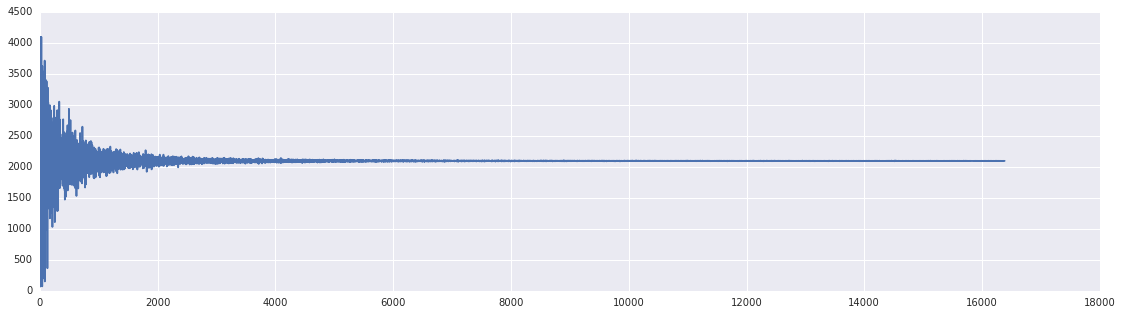

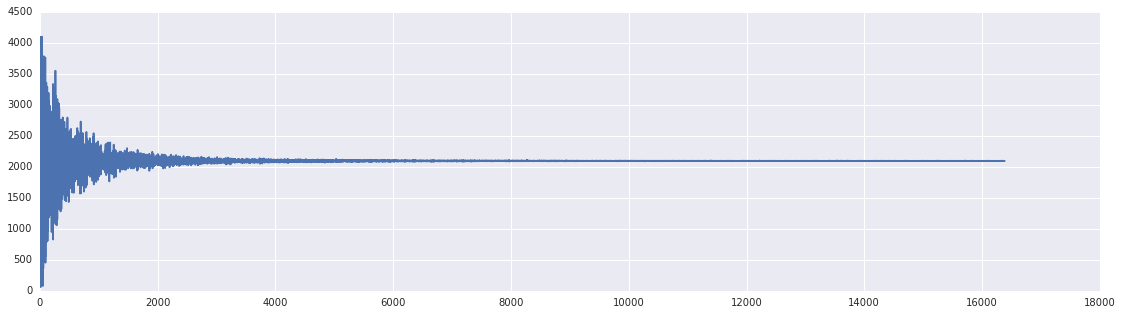

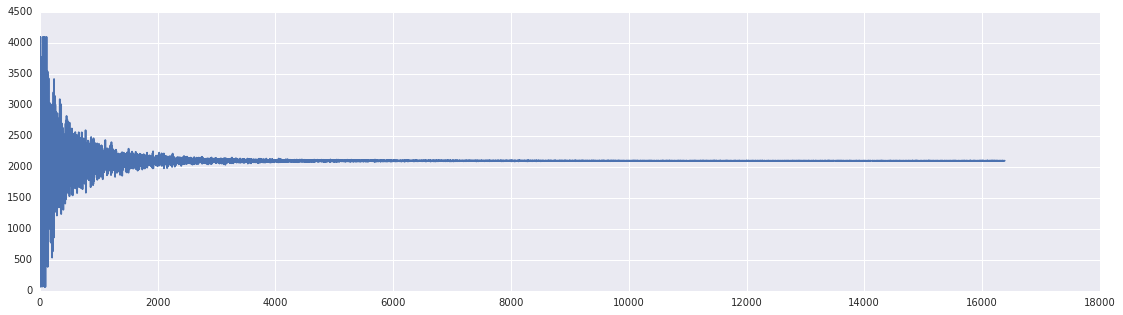

In [88]:
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (19, 5)

for i in np.random.choice(range(samples_mat.shape[0]), 3, replace=False):
    plt.plot(samples_mat[i,:])
    plt.show()

# Предсказание gallons

In [75]:
import scipy as sp


def list_to_matrix(list_like):
    if sp.sparse.issparse(list_like[0]):
        return sp.sparse.vstack(list_like)
    else:
        return np.vstack(list_like)

    

def vectorize(df):
    df_columns = [df.ix[:, i].values for i in range(df.shape[1])]
    df_matrixes = map(list_to_matrix, df_columns)

    if any([sp.sparse.issparse(m) for m in df_matrixes]):
        X = sp.sparse.hstack(df_matrixes).tocsr()
    else:
        X = np.hstack(df_matrixes)
    return X


In [39]:
import sklearn
import sklearn.cross_validation
import sklearn.linear_model
import sklearn.metrics

In [112]:
def regression_report(model, X, y):
    y_pred = model.predict(X)
    
    print '\t MSE: {:.2f}'.format(sklearn.metrics.mean_squared_error(y, y_pred))
    print '\t MAE: {:.2f}'.format(sklearn.metrics.mean_absolute_error(y, y_pred))
    
    
def regression_report_train_valid(model, X_train, X_valid, y_train, y_valid):
    model.fit(X_train, y_train)
    print 'Train:'
    regression_report(model, X_train, y_train)
    print 'Valid:'
    regression_report(model, X_valid, y_valid)
    
    y_valid_pred = model.predict(X_valid)
    plt.figure(figsize=(6, 4))
    sns.distplot(y_valid - y_valid_pred, bins=40, label='AAA', axlabel='Validation residuals')

## Модели на без учета данных sample

In [77]:
X_raw = samples_df[['battery_voltage','pot_setting','pressure','temperature']]

X = vectorize(X_raw)
y = samples_df.gallons.values

X_train, X_valid, y_train, y_valid = sklearn.cross_validation.train_test_split(X, y, train_size=0.7)
print 'Train size: {0}, validation size: {1}'.format(X_train.shape[0], X_valid.shape[0])

Train size: 882, validation size: 378


### Linear regression

Train:
	 MSE: 35.97
	 MAE: 5.17
Valid:
	 MSE: 35.29
	 MAE: 5.06


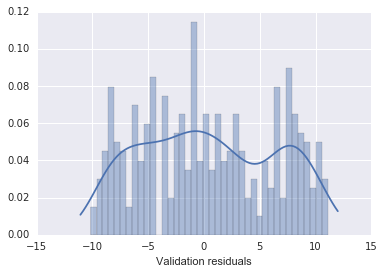

In [113]:
model = sklearn.linear_model.LinearRegression(
    copy_X=True, fit_intercept=True, n_jobs=1, normalize=False
)

regression_report_train_valid(model, X_train, X_valid, y_train, y_valid)

### Suppor Vector Regression (rbf kernel, default parameters)

Train:
	 MSE: 29.97
	 MAE: 3.55
Valid:
	 MSE: 25.49
	 MAE: 3.29


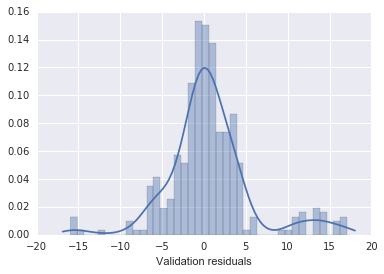

In [119]:
model = sklearn.svm.SVR(kernel='rbf')#, C=1e3, gamma=0.1)

regression_report_train_valid(model, X_train, X_valid, y_train, y_valid)

### Suppor Vector Regression (rbf kernel, parameters estimated by grid search cross-validation)

In [130]:
model = sklearn.grid_search.GridSearchCV(
    estimator=sklearn.svm.SVR(),
    param_grid={
        'kernel': ['rbf'],
        'C': [4**i for i in range(0, 5)],
        'gamma': [4**i for i in range(0, 5)]
    },
    refit=True,
    n_jobs=4,
    cv=5,
    verbose=True
)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Train:
	 MSE: 0.75
	 MAE: 0.47
Valid:
	 MSE: 0.80
	 MAE: 0.54


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    8.1s finished


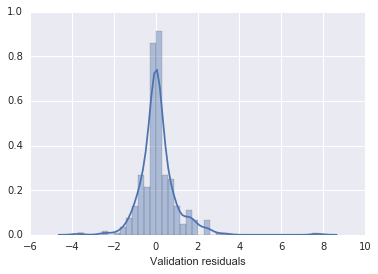

In [131]:
regression_report_train_valid(model, X_train, X_valid, y_train, y_valid)

In [134]:
model.best_params_

{'C': 256, 'gamma': 4, 'kernel': 'rbf'}